In [1]:
# critical-state-correlations.ipynb
#
# Bryan Daniels
#
# 11.21.2017
#
# Calculate critical transition index as defined in 
# "Cell fate decision as high-dimensional critical transition"
# Mojtahedi et al., PLOS Biology 14 (12): e2000640 (2016) 
#

In [1]:
from toolbox import setDefaultParams
setDefaultParams()

In [2]:
import pandas
import scipy, pylab
import numpy as np
import matplotlib.pyplot as plt
from toolbox import aboveDiagFlat

In [3]:
xlFile = pandas.ExcelFile("../../Data/170614/nanostring data with VG protein data.xlsx")
rawData = xlFile.parse('Sheet1')

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
# pull out just the age and expression data, indexed by age
data = rawData.set_index(['Age']).loc[:,'4ebp1':'VG protein ']

In [5]:
data.index.unique()

Int64Index([1, 3, 4, 6, 10, 15], dtype='int64', name='Age')

# deal with outlier on day 4

In [6]:
# 2022/2/25 just ignore day 4 completely...
removeDay4 = True
if removeDay4:
    data.drop(4,inplace=True)

In [7]:
# one bee on day 4 has much larger expression for most genes.
# we can identify it as the one that has 4ebp1 expression > 40000
# (see correlations.ipynb for more details)
outlier = data['4ebp1'] > 40000
notOutlier = data['4ebp1'] < 40000

# calculate correlations

In [8]:
import numpy as np
import scipy.stats
import pandas as pd

In [9]:
data.shape

(80, 91)

In [10]:
def corrs(data,day,log=True,transpose=False,includeOutlier=False,includeVGprotein=False,
         method='pearson'):

    if includeOutlier:
        d = data.loc[day].copy()
    else:
        d = data[notOutlier].loc[day].copy()

    if log:
        d = np.log(d).copy()
        
    if not includeVGprotein:
        d = d.drop('VG protein ',axis=1,errors='ignore').copy()
        
    if transpose:
        c = np.asarray(d.T.corr(method=method))
    else:
        c = np.asarray(d.corr(method=method))
        
    return aboveDiagFlat(c)

In [11]:
def correlationPlot(data,log=True,includeOutlier=False,includeVGprotein=False,
                    method='pearson'):
    days = data.index.unique()
    c = lambda day,transpose: corrs(data,day,log=log,transpose=transpose,
                                    includeOutlier=includeOutlier,
                                    includeVGprotein=includeVGprotein,
                                    method=method)

    pylab.figure(figsize=(12,3))

    pylab.subplot(1,3,1)
    pylab.errorbar(days,[np.mean(np.abs(c(day,False))) for day in days],
                   yerr=[np.std(np.abs(c(day,False)))/np.sqrt(len(c(day,False))) for day in days],
                   marker='o',ls=':')
    pylab.xlabel('day')
    pylab.ylabel('mean gene-gene\ncorrelation')
    pylab.axis(ymin=0,ymax=1)

    pylab.subplot(1,3,2)
    pylab.errorbar(days,[np.mean(c(day,True)) for day in days],
                   yerr=[np.std(c(day,True))/np.sqrt(len(c(day,True))) for day in days],
                   marker='o',ls=':',color='C2')
    pylab.xlabel('day')
    pylab.ylabel('mean bee-bee\ncorrelation')
    pylab.axis(ymin=0,ymax=1)

    pylab.subplot(1,3,3)
    pylab.plot(days,[np.mean(np.abs(c(day,False)))/np.mean(c(day,True)) for day in days],
               'o:',color='C3')
    pylab.xlabel('day')
    pylab.ylabel('transition index')
    pylab.axis(ymin=0)

    pylab.subplots_adjust(wspace=0.5)

In [12]:
def transitionIndexPlot(data,log=True,includeOutlier=False,includeVGprotein=False,
                        method='pearson',color='C3',marker='o',label=''):
    days = data.index.unique()
    c = lambda day,transpose: corrs(data,day,log=log,transpose=transpose,
                                        includeOutlier=includeOutlier,
                                        includeVGprotein=includeVGprotein,
                                        method=method)
    plt.plot(days,[np.mean(np.abs(c(day,False)))/np.mean(c(day,True)) for day in days],
                   ls=':',color=color,marker=marker,label=label,markersize=10,mec='k',mew=0.1)
    pylab.xlabel('Day')
    pylab.ylabel('Transition index')
    pylab.axis(ymin=0)

# 2022/2/28 plot comparing transition index plot as we gradually focus on genes most that we most associate with the transition

In [13]:
fracVarAlongPCday10 = pd.read_csv('220224_fraction_variance_along_PC_day_10.csv',names=['gene','fracVar'],skiprows=1)
fracVarAlongPCday15 = pd.read_csv('220224_fraction_variance_along_PC_day_15.csv',names=['gene','fracVar'],skiprows=1)

In [14]:
# we'll include genes that appear above a given threshold on both days 10 and 15
# (calculate for many thresholds, then choose threshold based on number of genes we want)
threshVals = np.linspace(0,1,1000)
genesDay10and15list,numGenesList = [],[]
for thresh in threshVals:
    genesDay10 = set(fracVarAlongPCday10[fracVarAlongPCday10['fracVar']>thresh]['gene'])
    genesDay15 = set(fracVarAlongPCday15[fracVarAlongPCday15['fracVar']>thresh]['gene'])
    genesDay10and15 = genesDay10.intersection(genesDay15)
    genesDay10and15list.append( genesDay10and15 )
    numGenesList.append( len(genesDay10and15) )

Top 10 genes: {'vg', 'Hex70a', 'PRM1', 'P110', 'Def2', 'LOC409966', 'Malvolio', 'ilp1', 'hex 110', 'Hymenoptaecin'}
Top 20 genes: {'LOC409966', 'TYR1', 'VG protein ', 'SmG', 'AGO2', 'P110', 'hex 110', 'TOR', 'Hex70a', 'PRM1', 'transferrin 1', 'vg', 'Def2', 'Malvolio', 'ilp1', 'Kr-h1', 'JHE', 'erk7', 'MRJP-3', 'Hymenoptaecin'}
Top 50 genes: {'SVP NR2F1', 'LOC726648', 'Dop1', 'egfr', 'LOC409966', 'InR1', 'TYR1', 'Br-c', 'SmG', 'VG protein ', 'ILP-2', 'Ethr', 'Mob3', 'Dop3', 'AGO2', 'Tbh', 'E74', 'erk7', 'P110', 'Rheb', 'MRJP-5', 'hex 110', 'Def', 'Chd64', 'TOR', 'dnmt3', 'PKG (For)', 'Hex70a', 'PRM1', 'OA1 or OAR', 'InR2', 'transferrin 1', 'Def2', 'vg', 'Malvolio', 'ilp1', 'LOC726899 GB52437', 'dnmt1a', 'USP (RXR)', 'AKT1', 'Kr-h1', 'LOC406144', 'MRJP-3', 'JHE', 'MRJP-9', 'vgR', 'JHEH', 'Mkp3', 'if', 'Hymenoptaecin'}


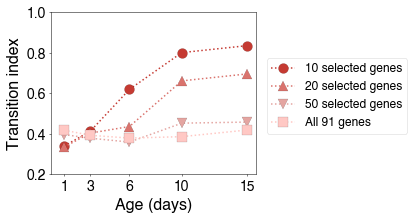

In [173]:
plt.figure(figsize=(6,3))
colors,shapes = ['#C53A32','#DA736D','#E4A5A1','#FFC8C4'],['o','^','v','s']
for nGenes,color,shape in zip([10,20,50,91],colors,shapes):
    selectedGenes = genesDay10and15list[ numGenesList.index(nGenes) ]
    if nGenes < 91: 
        print("Top {} genes: {}".format(nGenes,selectedGenes))
        label = '{} selected genes'.format(nGenes)
    else:
        label = 'All 91 genes'
    transitionIndexPlot(data[selectedGenes],includeVGprotein=True,color=color,marker=shape,
                        label=label)
plt.xlabel('Age (days)')
plt.axis(xmin=0,ymin=0.2,ymax=1)
plt.xticks(data.index.unique())
leg = plt.legend(loc=(1.05,0.25))
plt.subplots_adjust(right=0.6,bottom=0.2,top=0.95)
defaultFigure.makePretty(leg=leg)
plt.savefig('220307_huang_transition_index_vs_time.pdf')